## Plan

Compare 2 imbalanced learning techniques

- Undersampling

- Oversampling / SMOTE


1. Undersample data to get even classes
2. Visualise Data through tSNE to inspect any patterns / separability
3. Fit a Random Forest (RF) to the undersampled data - analyse metrics
4. Oversample by using Synthetic Minority Over-sampling Technique to generate synthetic data
5. Fit an RF on the oversampled data
6. Compare model performance metrics between undersampled and oversampled data

In [63]:
import pandas as pd
import numpy as np
import operator
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import imblearn
from imblearn.over_sampling import SMOTE
import itertools
from collections import Counter
from sklearn.metrics import confusion_matrix,precision_recall_curve,auc,\
roc_auc_score,roc_curve,recall_score,precision_score,classification_report,f1_score
from sklearn.model_selection import cross_val_score
import warnings
import time

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster')

In [64]:
# read in data
df = pd.read_csv('../input/creditcard.csv')
# drop time and Amount - the non PCA features
df.drop(['Time','Amount'],axis=1,inplace=True)
# shuffle data
df.sample(frac=1.).reset_index(drop=True,inplace=True)
df.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


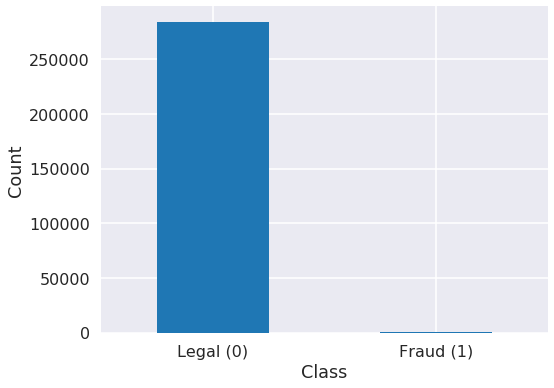

In [65]:
fig, ax = plt.subplots(figsize=(8,6))
df.groupby(['Class'])['Class'].count().plot(kind='bar')
plt.xticks([0,1],['Legal (0)','Fraud (1)'], rotation=0)
plt.ylabel('Count')
plt.show()

### Imbalanced Data...

Clearly, from the plot above, we can see that the classes in this data set are severly imbalanced.

Training a classifer on the raw data will greatly harm performance; as $>99.9\%$ of cases are legal, the classifer will only learn to classify every new example as Legal, and never classify anything as Fraud; the classifer will be extremely biased.

To overcome this bias, we need a more even distribution of classes that the classifier will be trained on. For this reason, we experiment with **undersampling** and **oversampling.**

# Undersampling

Our first method will be to undersample the data, so that we have even classes - Fraud / Legal transactions. We use all the fraud examples, and the same amount of a random selection of legal examples.

In [66]:
n_fraud_records = len(df[df['Class'] == 1])
fraud_indices = np.array(df[df['Class'] == 1].index)
normal_indices = df[df.Class == 0].index
# choose a random sample of legal cases, equal in count to fraud cases
random_normal_indices = np.array(np.random.choice(normal_indices, n_fraud_records, replace=False))
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = df.loc[under_sample_indices,:]
under_sample_data.reset_index(drop=True,inplace=True)

X = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y = under_sample_data.loc[:, under_sample_data.columns == 'Class']

X = X.as_matrix()
y = y.as_matrix()
y = y.T[0]

In [67]:
print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data['Class']==0])/len(under_sample_data))
print("Percentage of fraud transactions: ",len(under_sample_data[under_sample_data['Class']==1])/len(under_sample_data))
print("Total number of transactions in under sampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.5
Percentage of fraud transactions:  0.5
Total number of transactions in under sampled data:  984


## tSNE

Visualise the undersampled data to see if it is separable.

In [68]:
tsne = TSNE(n_components=2, random_state=np.random.randint(100))
matrix_2d = tsne.fit_transform(X)

In [69]:
colors = ['G' if i==0 else 'R' for i in y]

In [70]:
df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Class'] = under_sample_data['Class']
df_tsne['color'] = colors
df_tsne.columns = ['x','y','Class','color']
cols = ['Class','color','x','y']
df_tsne = df_tsne[cols]
df_tsne.head()

,Class,color,x,y
0,1,R,-25.203880,-22.463606
1,1,R,9.684385,-6.382430
2,1,R,-18.546957,-26.988125
3,1,R,-13.506587,-43.389263
4,1,R,-14.991433,0.495072


In [71]:
# number of rows and columns
df_tsne.shape

(984, 4)

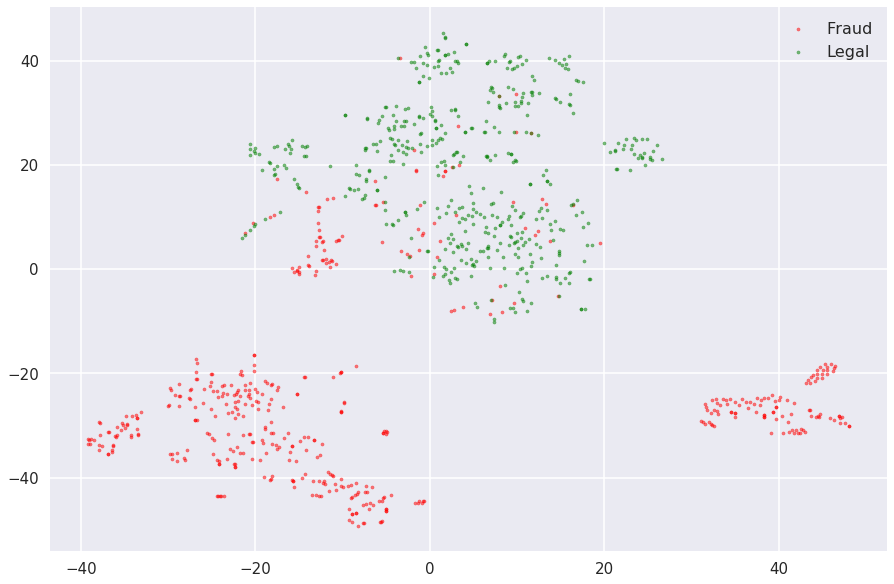

In [72]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['Class']==1].x.values, df_tsne[df_tsne['Class']==1].y.values,
           c='red', s=10, alpha=0.5, label='Fraud')
ax.scatter(df_tsne[df_tsne['Class']==0].x.values, df_tsne[df_tsne['Class']==0].y.values,
           c='green', s=10, alpha=0.5, label='Legal')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show();

We can see there are definite distinct regions of points of the same class; in particular 2 clear Fraud clusters containing mainly Fraud cases, and 1 legal cluster with a few Fraud samples mixed in. This tells us that our data is mostly separable and our classifier should perform well.

However, there are some fraud cases that are mixed in closely with the legal cases, at least after tSNE reduction. This may make it harder to classify these cases.

## Random Forests

A Random Forest is a bagging ensemble of decision tree classifiers, where each tree votes on a class and the majority classification is taken in the end. Bagging is a technique by which each training example is taken and **replaced**, so that on average each tree has 2/3 unique examples and 1/3 duplicates. This reduces the variance in the model. RF's use $\sqrt{p}$ random features for each tree ($p$ is the total number of features), meaning the model is less prone to overfitting if some features are missing from tress.

Information gain determines the most effective feature to use when splitting on a decision tree node. The metric
measures the decrease in entropy by using a specific feature. Given a classification $c$ and a feature vector $x$ with component $x_k$, the information gained (IG) by including feature $x_k$ is defined as

$$IG(c|x_k) = H(c)-H(c|x_k)$$

$$H(x) = -\sum_i^{n_c}p_{c_i}\log_2(p_{c_i})$$

where H is the entropy of a dataset with $n_c$ classes, $p_{c_i}$ is the probability of selecting that class. The larger the value of the information gain, the more effective the feature is at classifying
the data. Decision trees split on nodes based on which features yield the most information
gain.

### Accuracy metrics

We will train our model using a varying number of trees, then inspect the performance metrics on each iteration and use these to determine the optimal number of trees to use in our RF.

Let's bear in mind that we absolutely do not want to miss a fraud case - in other words, we want our _False Negative_ measure to be as low as possible. This corresponds to maximising the Recall and F1 scores, which we will visualise below.

In [73]:
# split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=np.random.randint(100))

In [74]:
scores_dict = {num_trees:[] for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
k = 10
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    warnings.filterwarnings("ignore")
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=10, oob_score=True)
    scores = cross_val_score(clf, X_train, y_train, cv=k, n_jobs=-1)
    model = clf.fit(X_train, y_train)
    preds = model.predict(X_test)
    precision = precision_score(y_test, preds)
    recall = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    scores_dict[num_trees].append([scores.mean(), precision, recall, f1])
    temp_oob = 1 - clf.oob_score_
    oob_err_dict[num_trees] = temp_oob

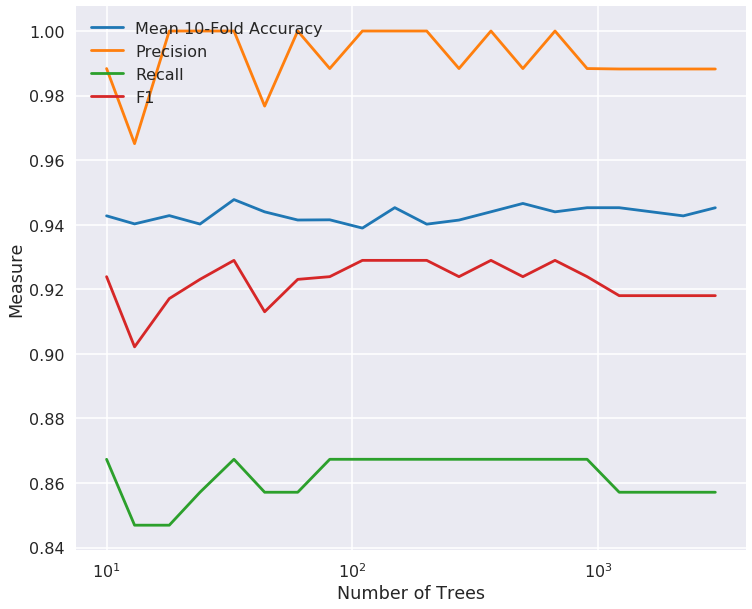

In [75]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(scores_dict.keys()),[elem[0][0] for elem in scores_dict.values()], '-', label='Mean 10-Fold Accuracy')
ax.semilogx(list(scores_dict.keys()),[elem[0][1] for elem in scores_dict.values()], '-', label='Precision')
ax.semilogx(list(scores_dict.keys()),[elem[0][2] for elem in scores_dict.values()], '-', label='Recall')
ax.semilogx(list(scores_dict.keys()),[elem[0][3] for elem in scores_dict.values()], '-', label='F1')
ax.legend()
ax.set_xlabel('Number of Trees')
ax.set_ylabel('Measure')
# ax.set_ylim(0.89,1.)
plt.show()

We can see that all the metrics neither increase or decrease consistently as we add more than $\approx 100$ trees to the ensemble. In fact, these metrics just regress to the mean, which is a constant.

### OOB Error

One of the most common metrics to evaluate how many trees to be used in a model is the Out Of Bag Error. This is the mean error rate of predictions on samples _excluded from a trees bag of samples_, hence, out of bag. The metric measures this error as the number of trees in the ensemble varies.

The elbow in the OOB rate is usually the optimum number of trees to choose; adding more trees after this only yields diminishing returns, while also being less computationally efficient.

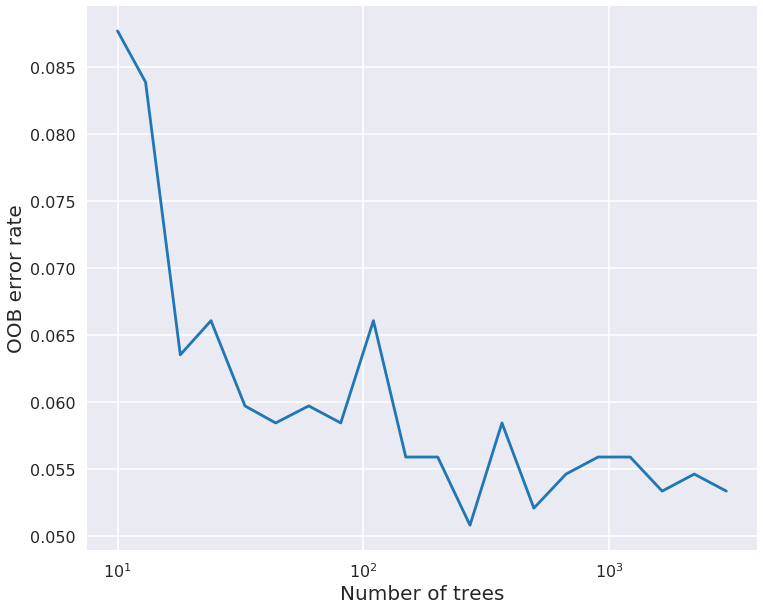

In [76]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(oob_err_dict.keys()), list(oob_err_dict.values()))
ax.set_xlabel('Number of trees', fontsize=20)
ax.set_ylabel('OOB error rate', fontsize=20)
plt.show()

### What did we learn?

The Accuracy, F1, Precision and Recall metrics yielded the same results on average between 100 and 10,000 trees. But the OOB Error indicates how well our model will generalise, so we use this as an indicator for number of trees to use; the OOB graph above shows that if we use above a few 100 trees, the RF should generalise well.

**As a quick and dirty rule, I sometimes use $2\sqrt{N}$ as the number of trees / layers to use.** Where N is the number of data samples when considering how many trees to use, or N is the number of features in the data when considering the max depth to allow trees to grow. Capping the max depth means the model is less likely to overfit and will generalise better. (Bear in mind, this rule doesnt always work; if for example you had many unique string / categorical variables that you had to one hot encode into new features, or if your dataset is very small / large).

Finally, I keep the maximum number of layers / depth of each tree to be at 10, to avoid overfitting and generalise better.

In [77]:
N_trees = 200
clf = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=10, criterion='entropy')
model = clf.fit(X_train, y_train)
preds = model.predict(X_test)

In [78]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix',cmap=plt.cm.Blues, norm=False):
    """
    This function prints and plots the confusion matrix
    """
    fig, ax = plt.subplots(figsize=(12,8))
    
    if norm == True:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round_(cm, decimals=3)
    
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
    tick_marks = np.arange(len(classes))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.grid(False)
    plt.show()

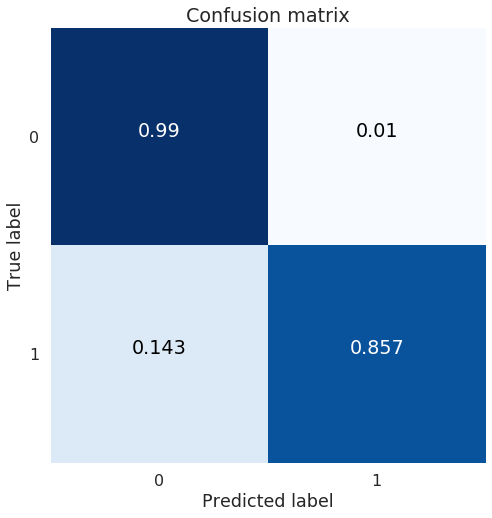

In [79]:
cnf_matrix = confusion_matrix(y_test,model.predict(X_test))
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix', norm=True)

In [80]:
print("Recall:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0]))
print("Precision:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1]))

Recall: 0.857142857143
Precision: 0.988235294118


### ROC Curve

Currently, the model uses a threshold of 50% - if 50% or more trees vote one class, that class will be the final classification. Varying that threshold will change the models preformance. We vary the probability threshold output by the model to calculate how the True Positive Rate and False Positive Rates vary; this is known as the Receiver Operator Characteristic curve.

On a ROC curve, a perfect model would be at (0,1) - the closer to this point the models performance is, the more ideal the model. The Area Under the ROC curve - AUC - is another metric used to determines the models performance; the closer to $1$ this number is, the better the model

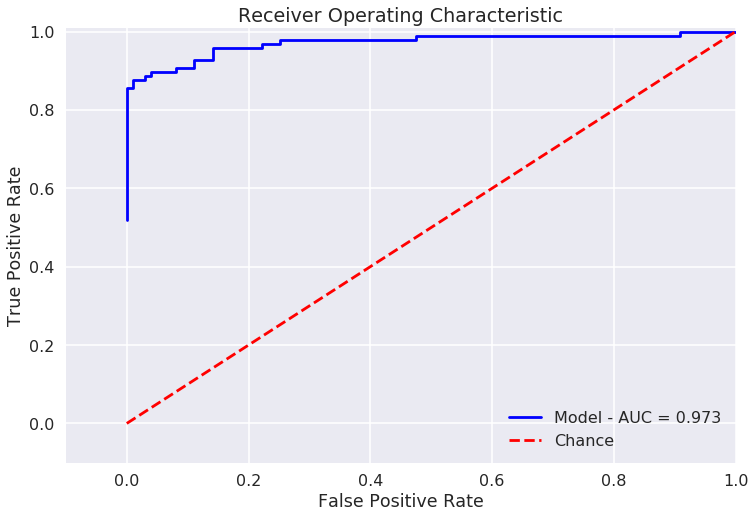

In [81]:
y_prob = clf.predict_proba(X_test)

pos_probs = [y_prob[i][1] for i in range(len(y_prob))]
    
fpr, tpr, threshold = roc_curve(y_test, pos_probs)
auc = roc_auc_score(y_test, pos_probs)

# Plot ROC
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Model - AUC = %0.3f'% auc)
ax.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--', label='Chance')
ax.legend()
ax.set_xlim([-0.1,1.0])
ax.set_ylim([-0.1,1.01])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

### Precision Recall Curve

We vary thresholds again, simialr to the ROC curve, and this time plot Precision and Recall. In this case, the perfetc model will be at $(1,1)$, in the top right of the plot.

This visualisation gives us a sense of the tradeoff we make by changing the threshold; too low and everything will be classified as Fraud, meaning we will catch all Fraud cases but misclassify legal cases; too high and we will miss many Fraud cases.

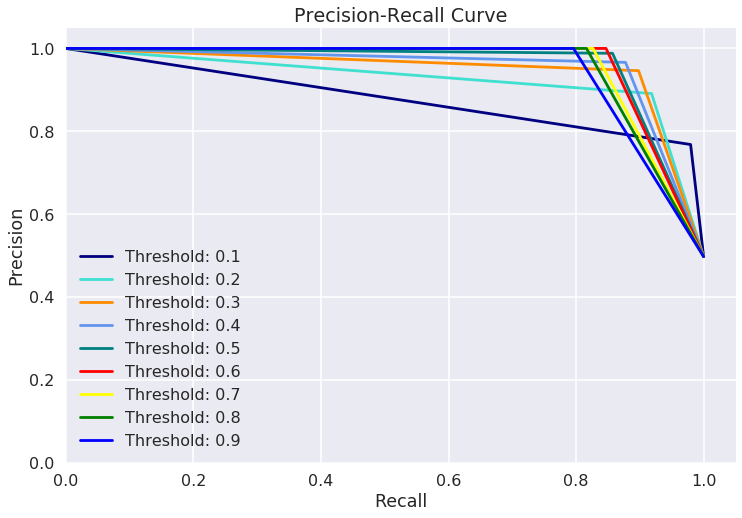

In [82]:
y_prob = model.predict_proba(X_test)

thresholds = np.linspace(start=0.1,stop=0.9,num=9)
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black']

plt.figure(figsize=(12,8))

for i,color in zip(thresholds,colors):
    # boolean values if the probability of a fraud classification is above the threshold
    y_bool = y_prob[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_bool)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
plt.show()

### Undersampled Data conclusions

The model performed very well on the undersampled data - an AUROC of > 0.95 and Precision and Recall bog above $0.9$.

The lower precision is most likely cuased by the Fraud cases that are "close" to the Legal cases, in a feature space euclidean sense. These were the red points mixed in with the green cluster in the tSNE plot above.

We could change the voting threshold from it's threshold of 50% to a slightly lower value which would increase the Recall, but we wont for now, and will move on instead to generating synthetic data using SMOTE.

# SMOTE

Synthetic Minority Over-sampling Technique is a beautiful little technique to deal with imbalanced data. And luckily, python has a library for it: imblearn.


The technique works by finding the nearest neighbour of minority samples, taking their difference and multiplying this by a random number. In essence, you can think of it as perturbing the feature vectors of the minority class samples. So simple, and works surprisingly well to increase model accruacy.

After performing SMOTE, the classes are balanced - the number of synthetic examples are now equal to the number of (real) majority classes. For efficiency reasons, we generate some $\approx 9,000$ Fraud cases, keep the original $\approx 400$ cases, and use $\approx 10,000$ (real) legal cases.

Note that only data for the minority class is genereted; the majority class data is left untouched.

In [83]:
n_fraud_records = len(df[df['Class'] == 1])
fraud_indices = np.array(df[df['Class'] == 1].index)
normal_indices = df[df.Class == 0].index
# amount to oversample by
factor = 20
random_normal_indices = np.array(np.random.choice(normal_indices, int(20*n_fraud_records), replace=False))
under_sample_indices = np.concatenate([fraud_indices, random_normal_indices])
under_sample_data = df.loc[under_sample_indices,:]
under_sample_data.reset_index(drop=True,inplace=True)

X = under_sample_data.loc[:, under_sample_data.columns != 'Class']
y = under_sample_data.loc[:, under_sample_data.columns == 'Class']

X = X.as_matrix()
y = y.as_matrix()
y = y.T[0]

print("Percentage of normal transactions: ", len(under_sample_data[under_sample_data['Class']==0])/len(under_sample_data))
print("Percentage of fraud transactions: ",len(under_sample_data[under_sample_data['Class']==1])/len(under_sample_data))
print("Total number of transactions in under sampled data: ", len(under_sample_data))

Percentage of normal transactions:  0.9523809523809523
Percentage of fraud transactions:  0.047619047619047616
Total number of transactions in under sampled data:  10332


In [84]:
y = np.reshape(y, newshape=(-1,))
print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({0: 9840, 1: 492})


In [85]:
smote = SMOTE(ratio='auto', random_state=np.random.randint(100), k_neighbors=5, 
              m_neighbors=10, kind='regular', n_jobs=-1)

In [86]:
X_res, y_res = smote.fit_sample(X, y)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({1: 9840, 0: 9840})


In [87]:
matrix_2d = tsne.fit_transform(X_res)

In [88]:
colors = ['G' if i==0 else 'R' for i in y_res]

In [89]:
df_tsne = pd.DataFrame(matrix_2d)
df_tsne['Class'] = y_res
df_tsne['color'] = colors
df_tsne.columns = ['x','y','Class','color']
cols = ['Class','color','x','y']
df_tsne = df_tsne[cols]
df_tsne.head()

,Class,color,x,y
0,1,R,-67.000076,21.451870
1,1,R,11.562280,19.151735
2,1,R,-74.188469,-25.097303
3,1,R,67.252296,-16.148031
4,1,R,-54.882721,-65.848396


In [90]:
df_tsne.shape

(19680, 4)

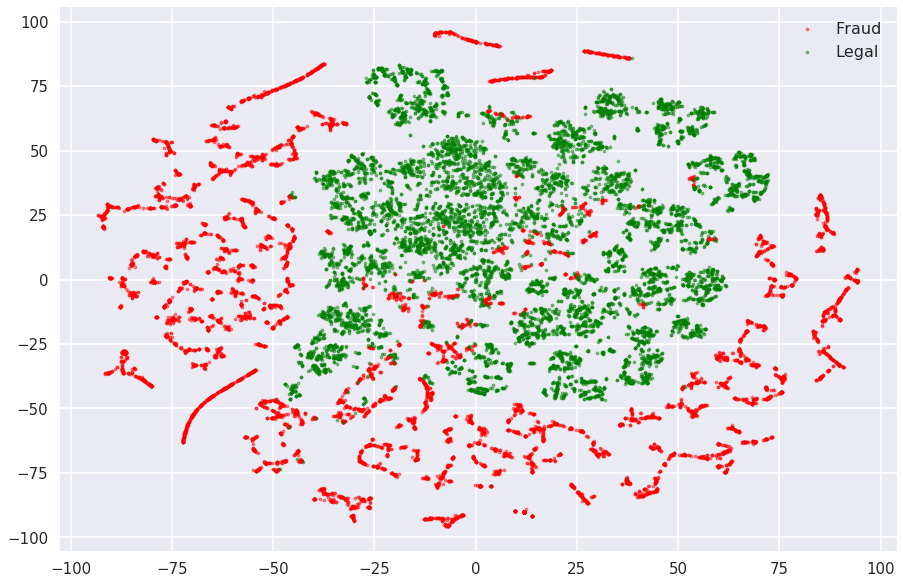

In [91]:
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(df_tsne[df_tsne['Class']==1].x.values, df_tsne[df_tsne['Class']==1].y.values,
           c='red', s=10, alpha=0.5, label='Fraud')
ax.scatter(df_tsne[df_tsne['Class']==0].x.values, df_tsne[df_tsne['Class']==0].y.values,
           c='green', s=10, alpha=0.5, label='Legal')
ax.tick_params(axis='both', which='major', labelsize=15)
ax.legend()
plt.show();

We can see that tSNE on the oversampled SMOTE data shows really well defined regions, with Fraud samples "surrounding" the legal cases. Some of the fraud cases that were previously closed and mixed in with the legal cases, in the centre of the tSNE plot, are more numerous; higher dimensions, these will be potentially easier to discriminate from legal cases.

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.2, random_state=np.random.randint(100))

In [93]:
oob_err_dict = {num_trees:0 for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int)}
for num_trees in np.logspace(start=1,stop=3.478,num=20).astype(int):
    warnings.filterwarnings("ignore")
    clf = RandomForestClassifier(n_estimators=num_trees, n_jobs=-1, max_depth=10, oob_score=True)
    model = clf.fit(X_train, y_train)
    temp_oob = 1 - clf.oob_score_
    oob_err_dict[num_trees] = temp_oob
    print("trained with:",num_trees,"trees")

trained with: 10 trees
trained with: 13 trees
trained with: 18 trees
trained with: 24 trees
trained with: 33 trees
trained with: 44 trees
trained with: 60 trees
trained with: 81 trees
trained with: 110 trees
trained with: 149 trees
trained with: 201 trees
trained with: 272 trees
trained with: 367 trees
trained with: 495 trees
trained with: 669 trees
trained with: 904 trees
trained with: 1221 trees
trained with: 1648 trees
trained with: 2226 trees
trained with: 3006 trees


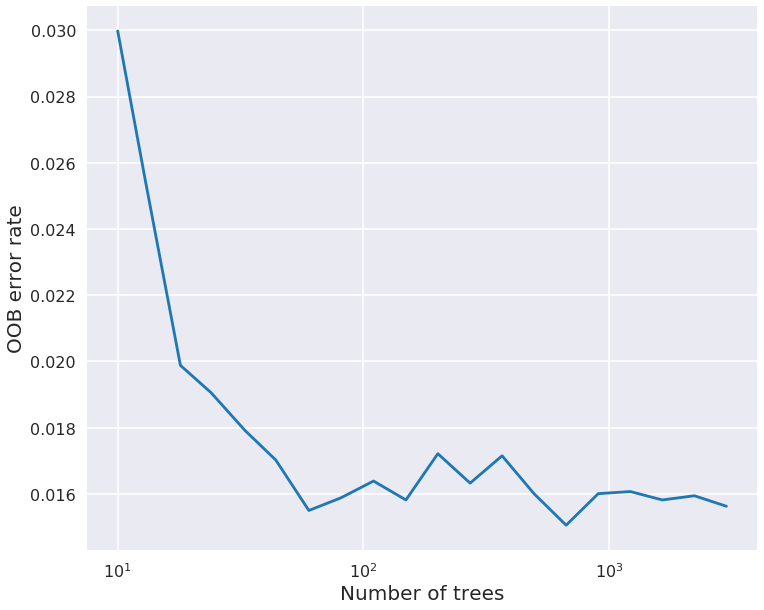

In [94]:
fig, ax = plt.subplots(figsize=(12,10))
ax.semilogx(list(oob_err_dict.keys()), list(oob_err_dict.values()))
ax.set_xlabel('Number of trees', fontsize=20)
ax.set_ylabel('OOB error rate', fontsize=20)
plt.show()

Once again, the optimal number of trees will be in the hundreds. We choose 200 again.

In [95]:
N_trees = 200
clf = RandomForestClassifier(n_estimators=N_trees, n_jobs=-1, max_depth=10)
model = clf.fit(X_train, y_train)

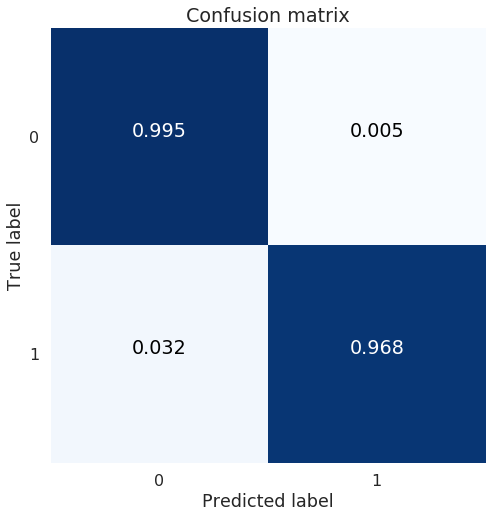

In [96]:
cnf_matrix = confusion_matrix(y_test,model.predict(X_test))
class_names = [0,1]
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Confusion matrix', norm=True)

In [97]:
print("Recall:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[1][0]))
print("Precision:", cnf_matrix[1][1]/(cnf_matrix[1][1]+cnf_matrix[0][1]))

Recall: 0.96844783715
Precision: 0.995292887029


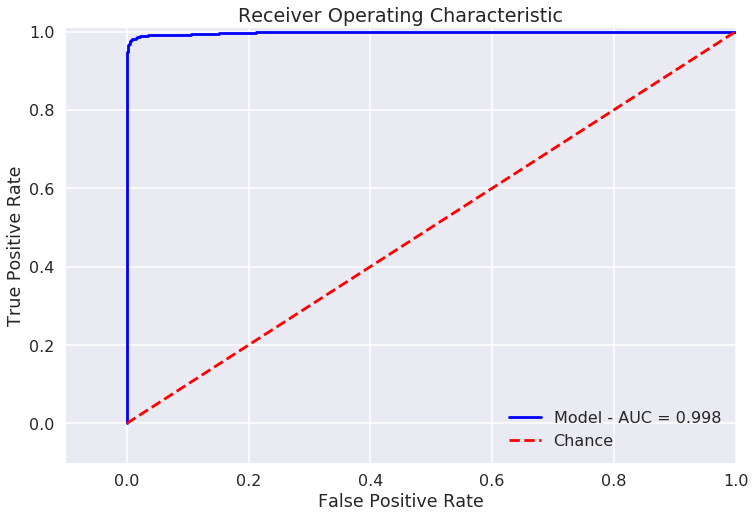

In [98]:
y_prob = clf.predict_proba(X_test)

pos_probs = [y_prob[i][1] for i in range(len(y_prob))]
    
fpr, tpr, threshold = roc_curve(y_test, pos_probs)
auc = roc_auc_score(y_test, pos_probs)

# Plot ROC
fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b',label='Model - AUC = %0.3f'% auc)
ax.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--', label='Chance')
ax.legend()
ax.set_xlim([-0.1,1.0])
ax.set_ylim([-0.1,1.01])
ax.set_ylabel('True Positive Rate')
ax.set_xlabel('False Positive Rate')
plt.show()

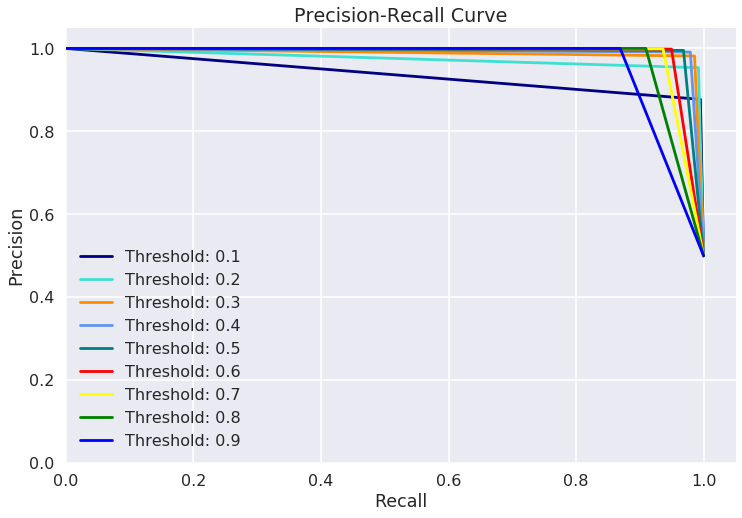

In [99]:
y_prob = model.predict_proba(X_test)

thresholds = np.linspace(start=0.1,stop=0.9,num=9)
colors = ['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal', 'red', 'yellow', 'green', 'blue','black']

plt.figure(figsize=(12,8))

for i,color in zip(thresholds,colors):
    # boolean values if the probability of a fraud classification is above the threshold
    y_bool = y_prob[:,1] > i
    
    precision, recall, thresholds = precision_recall_curve(y_test, y_bool)
    
    # Plot Precision-Recall curve
    plt.plot(recall, precision, color=color,label='Threshold: %s'%i)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.05])
    plt.title('Precision-Recall Curve')
    plt.legend(loc="lower left")
plt.show()

### Oversampeld SMOTE conclusions

The tSNE results of the SMOTE data do indeed show that fraud and legal cases are mostly separable.

The optimum number of trees to use from OOB remains the same as undersampling at around 200.

Most importantly, all performance metrics are greatly improved; AUROC, Recall and Precsion are all higher than the same metrics form the undersampled data. The Precsion Recall curve also shows that for all the same thresholds, the curves are much closer to $(1,1)$ than the undersampled data.


# Conclusions

Using tSNE to visualise the data has indeed shown that most Fraud and Legal cases are separable and distinct from each other. This would enable any classifier to perfrom well.

The RF classifer performs very well on the undersampled data, but the clear winner is oversampling using SMOTE; all performance metrics score higher, from 2-11%, using the latter method, as shown below. Furthermore, the Recall rate, which is the metric we would like ot maximise to catch Fraud cases, is superior when using SMOTE.


### Results Comparison

    Metric                         Undersampled         SMOTE

    AUROC                          0.973                0.998
    Recall (50% threshold)         0.857                0.968
    Precision (50% threshold)      0.988                0.995
    
    
If deploying a model to production, given the results above, we recommend generating synthetic data using SMOTE rather than undersampling, as the former has much higher Recall and slightly improved Precision.

# Extra: Feature Importance

The features we are given are anonymised and have been reduced by PCA, but for completeness we can still show which are the best indicators of fraud.

The Scikit Random forest implementation of `feature_importances_` is a metric that calculats which feature is most important by determining which feature yields the highest information gain.

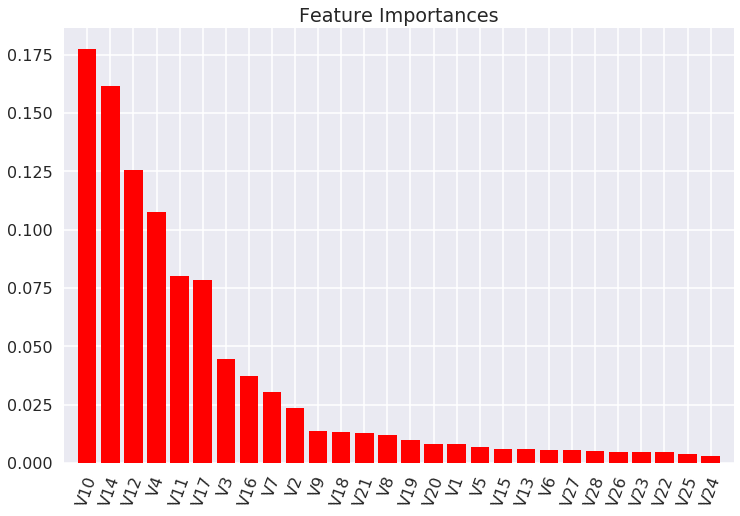

In [100]:
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(12,8))
ax.set_title('Feature Importances')
plt.bar(range(X_train.shape[1]), importances[indices],
       color='r', align='center')
ax.set_xticks(range(X.shape[1]))
ax.set_xticklabels([list(df.columns)[i] for i in indices], rotation=70)
ax.set_xlim([-1, X.shape[1]])
plt.show()

We can see that the most important features arre V10, V14 and V12, although as these are linear combinations of other anonymised features due to PCA, it is impossible to tell what these features are / signify.